### Imports and Definitions from Draco 2

In [3]:
# Display utilities
import json

import numpy as np
from IPython.display import Markdown, display


# Handles serialization of common numpy datatypes
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


def md(markdown: str):
    display(Markdown(markdown))


def pprint(obj):
    md(f"```json\n{json.dumps(obj, indent=2, cls=NpEncoder)}\n```")

In [9]:
import altair as alt
import pandas as pd
from vega_datasets import data as vega_data
from draco.renderer import AltairRenderer

import draco as drc

# Loading data to be explored
df: pd.DataFrame = vega_data.seattle_weather()
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


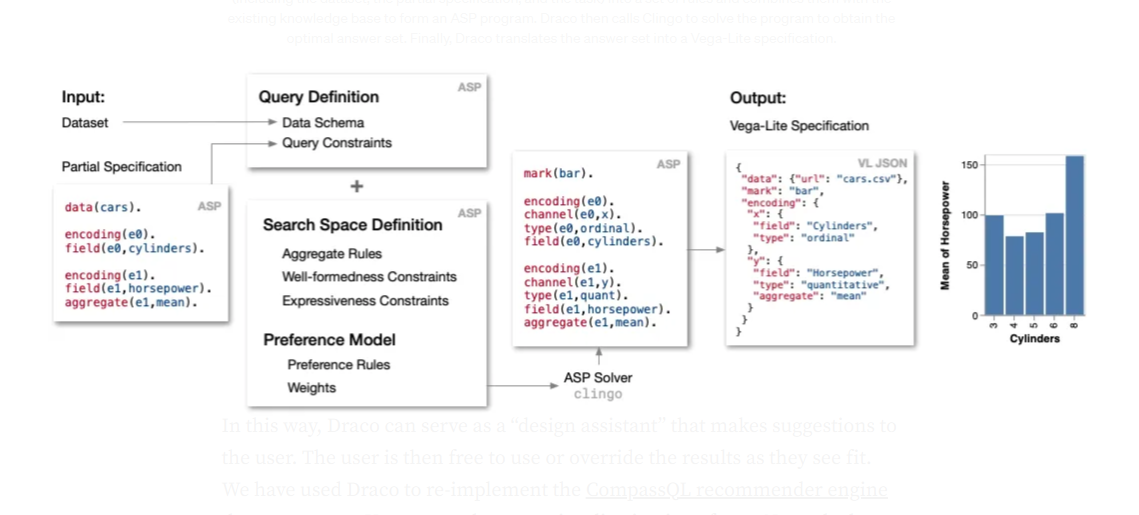

### Data Schema -> Draco Facts from Data

In [7]:
# At the beginning we extract the schema of the data that we have
data_schema = drc.schema_from_dataframe(df)
# pprint(data_schema)

# Now we can convert this schema to the facts that Draco can use later to reason about the data when generating recommendations
data_schema_facts = drc.dict_to_facts(data_schema)
# pprint(data_schema_facts)

### Partial Specification

In [10]:
input_spec_base = data_schema_facts + [
    "entity(view,root,v0).",
    "entity(mark,v0,m0).",
]
d = drc.Draco()
renderer = AltairRenderer()

In [36]:
def recommend_charts(
    spec: list[str], draco: drc.Draco, num: int = 5, labeler=lambda i: f"CHART {i+1}"
) -> dict[str, tuple[list[str], dict]]:
    # Dictionary to store the generated recommendations, keyed by chart name
    chart_specs = {}
    for i, model in enumerate(draco.complete_spec(spec, num)):
        chart_name = labeler(i)
        spec = drc.answer_set_to_dict(model.answer_set)

        # print(chart_name)
        # print(f"COST: {model.cost}")
        chart = renderer.render(spec=spec, data=df)
        # Adjust column-faceted chart size
        if (
            isinstance(chart, alt.FacetChart)
            and chart.facet.column is not alt.Undefined
        ):
            chart = chart.configure_view(continuousWidth=130, continuousHeight=130)
        # display(chart)

        chart_specs[chart_name] = drc.dict_to_facts(spec), spec, model.cost[0], chart

    return chart_specs

### Recommend Visualizations from Partial Specifications

In [37]:
input_spec = input_spec_base
initial_recommendations = recommend_charts(spec=input_spec, draco=d)

In [38]:
initial_recommendations

{'CHART 1': (['attribute(number_rows,root,1461).',
   'attribute(task,root,summary).',
   'entity(field,root,0).',
   'attribute((field,name),0,date).',
   'attribute((field,type),0,datetime).',
   'attribute((field,unique),0,1461).',
   'attribute((field,entropy),0,7287).',
   'entity(field,root,1).',
   'attribute((field,name),1,precipitation).',
   'attribute((field,type),1,number).',
   'attribute((field,unique),1,111).',
   'attribute((field,entropy),1,2422).',
   'attribute((field,min),1,0).',
   'attribute((field,max),1,55).',
   'attribute((field,std),1,6).',
   'entity(field,root,2).',
   'attribute((field,name),2,temp_max).',
   'attribute((field,type),2,number).',
   'attribute((field,unique),2,67).',
   'attribute((field,entropy),2,3934).',
   'attribute((field,min),2,-1).',
   'attribute((field,max),2,35).',
   'attribute((field,std),2,7).',
   'entity(field,root,3).',
   'attribute((field,name),3,temp_min).',
   'attribute((field,type),3,number).',
   'attribute((field,un

### Extend Partial Input Specification 

In [39]:
input_spec = input_spec_base + [
    # We want to encode the `date` field
    "entity(encoding,m0,e0).",
    "attribute((encoding,field),e0,date).",
    # We want to encode the `temp_max` field
    "entity(encoding,m0,e1).",
    "attribute((encoding,field),e1,temp_max).",
]
recommendations = recommend_charts(spec=input_spec, draco=d, num=5)

In [43]:
display(recommendations['CHART 1'][0])

['attribute(number_rows,root,1461).',
 'attribute(task,root,summary).',
 'entity(field,root,0).',
 'attribute((field,name),0,date).',
 'attribute((field,type),0,datetime).',
 'attribute((field,unique),0,1461).',
 'attribute((field,entropy),0,7287).',
 'entity(field,root,1).',
 'attribute((field,name),1,precipitation).',
 'attribute((field,type),1,number).',
 'attribute((field,unique),1,111).',
 'attribute((field,entropy),1,2422).',
 'attribute((field,min),1,0).',
 'attribute((field,max),1,55).',
 'attribute((field,std),1,6).',
 'entity(field,root,2).',
 'attribute((field,name),2,temp_max).',
 'attribute((field,type),2,number).',
 'attribute((field,unique),2,67).',
 'attribute((field,entropy),2,3934).',
 'attribute((field,min),2,-1).',
 'attribute((field,max),2,35).',
 'attribute((field,std),2,7).',
 'entity(field,root,3).',
 'attribute((field,name),3,temp_min).',
 'attribute((field,type),3,number).',
 'attribute((field,unique),3,55).',
 'attribute((field,entropy),3,3596).',
 'attribute

### Generating Input Specifications Programmatically

In [ ]:
def rec_from_generated_spec(
    marks: list[str],
    fields: list[str],
    encoding_channels: list[str],
    draco: drc.Draco,
    num: int = 1,
) -> dict[str, dict]:
    input_specs = [
        (
            (mark, field, enc_ch),
            input_spec_base
            + [
                f"attribute((mark,type),m0,{mark}).",
                "entity(encoding,m0,e0).",
                f"attribute((encoding,field),e0,{field}).",
                f"attribute((encoding,channel),e0,{enc_ch}).",
                # filter out designs with less than 2 encodings
                ":- {entity(encoding,_,_)} < 2.",
                # exclude multi-layer designs
                ":- {entity(mark,_,_)} != 1.",
            ],
        )
        for mark in marks
        for field in fields
        for enc_ch in encoding_channels
    ]
    recs = {}
    for cfg, spec in input_specs:

        def labeler(i):
            f"CHART {i + 1} ({' | '.join(cfg)})"

        recs = recs | recommend_charts(spec=spec, draco=draco, num=num, labeler=labeler)
        
    return recs

In [17]:
recommendations = rec_from_generated_spec(
    marks=["point", "bar", "line", "rect"],
    fields=["temp_min", "date"],
    encoding_channels=["color", "shape", "size"],
    draco=d,
)

None
COST: [27]


alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.FacetChart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.FacetChart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

### Try with Updating Knowledge Base

In [22]:
def draco_with_updated_kb(pref_weight: int) -> drc.Draco:
    # Custom soft constraint to discourage faceting with rect mark and color encoding
    rect_color_facet_pref = """
    % @soft(rect_color_facet) Faceting with rect mark and color encoding.
    preference(rect_color_facet,Fa) :-
        attribute((mark,type),_,rect),
        attribute((encoding,channel),_,color),
        attribute((facet,channel),Fa,_).
    """.strip()
    rect_color_facet_pref_weight = pref_weight

    # Update the default soft constraint knowledge base (program)
    soft_updated = drc.Draco().soft + f"\n\n{rect_color_facet_pref}\n\n"
    # Assign the weight to the new soft constraint
    weights_updated = drc.Draco().weights | {
        "rect_color_facet_weight": rect_color_facet_pref_weight
    }
    return drc.Draco(soft=soft_updated, weights=weights_updated)

In [24]:
weight = 0
display(Markdown(f"**Weight for `rect_color_facet` preference: {weight}**"))
updated_draco = draco_with_updated_kb(pref_weight=weight)
recommendations = rec_from_generated_spec(
    marks=["rect"],
    fields=["weather", "date"],
    encoding_channels=["color"],
    draco=updated_draco,
)
# display_debug_data(draco=updated_draco, specs=recommendations)

**Weight for `rect_color_facet` preference: 0**

None
COST: [69]


alt.FacetChart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.FacetChart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

In [23]:
weight = 10
display(Markdown(f"**Weight for `rect_color_facet` preference: {weight}**"))
updated_draco = draco_with_updated_kb(pref_weight=weight)
recommendations = rec_from_generated_spec(
    marks=["rect"],
    fields=["weather", "date"],
    encoding_channels=["color"],
    draco=updated_draco,
)
# display_debug_data(draco=updated_draco, specs=recommendations)

**Weight for `rect_color_facet` preference: 10**

None
COST: [72]


alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'